In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install deeplake[enterprise]

In [3]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [4]:
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



/

hub://activeloop/nih-chest-xray-test loaded successfully.



In [5]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomRotation(8),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [6]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

for i, layer in enumerate(model.features):
    if i % 2 == 0:
        for param in layer.parameters():
            param.requires_grad = False

num_labels = 15
in_features = model.classifier[6].in_features

in_features = 25088

classifier = nn.Sequential(
    nn.Linear(in_features, 1000),
    nn.ReLU(),
    nn.Linear(1000, num_labels),
    nn.Sigmoid()
)

model.classifier = classifier

In [7]:
def class_averaged_binary_cross_entropy(preds, targets):
  num_classes = 15
  loss = 0

  for c in range(num_classes):
    loss_c = F.binary_cross_entropy(preds[:, c], targets[:, c])
    loss += loss_c

  loss /= num_classes

  return loss

In [8]:
def load_model(result_file_model, model_to_load, model, epoch, device):
    model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f'Model loaded from {model_save_path}')
    return model

In [9]:
labels = test_ds.findings.info.class_names
print(labels)

['No Finding', 'Hernia', 'Emphysema', 'Nodule', 'Pneumonia', 'Consolidation', 'Cardiomegaly', 'Effusion', 'Mass', 'Pleural_Thickening', 'Atelectasis', 'Pneumothorax', 'Fibrosis', 'Infiltration', 'Edema']


In [10]:
model_name = "SSN_VGG16"
result_file_model = "/content/drive/MyDrive/models"
epoch = 10

criterion = class_averaged_binary_cross_entropy

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

loaded_model = load_model(result_file_model, model_name, model, epoch, device)
loaded_model.to(device)

Running on cuda
Model loaded from /content/drive/MyDrive/models/SSN_VGG16_checkpoint_epoch_10.pt


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [11]:
# Containers to store predictions and true labels
all_preds = torch.tensor([]).to(device)
all_labels = torch.tensor([]).to(device)

# Go through the train_loader
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        output = model(data)
        all_preds = torch.cat((all_preds, output), dim=0)
        all_labels = torch.cat((all_labels, label), dim=0)

In [12]:
all_preds

tensor([[5.6455e-01, 4.9481e-03, 2.4245e-02,  ..., 5.2168e-02, 1.7149e-01,
         4.5808e-03],
        [7.1882e-01, 5.8756e-04, 3.3542e-03,  ..., 2.5356e-02, 8.6628e-02,
         4.2584e-04],
        [6.2621e-01, 6.1282e-03, 1.1404e-02,  ..., 3.0439e-02, 1.1935e-01,
         3.7475e-03],
        ...,
        [8.7414e-01, 1.6838e-04, 5.1641e-04,  ..., 5.0500e-03, 1.0115e-01,
         6.6961e-05],
        [8.4797e-01, 2.6134e-04, 9.2860e-04,  ..., 8.1836e-03, 1.0007e-01,
         2.4415e-04],
        [8.4809e-01, 3.1154e-04, 4.7503e-04,  ..., 4.7137e-03, 9.0653e-02,
         5.5374e-04]], device='cuda:0')

In [13]:
all_labels

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [14]:
all_preds_sigmoid = torch.sigmoid(all_preds)

In [15]:
all_preds_sigmoid

tensor([[0.6375, 0.5012, 0.5061,  ..., 0.5130, 0.5428, 0.5011],
        [0.6723, 0.5001, 0.5008,  ..., 0.5063, 0.5216, 0.5001],
        [0.6516, 0.5015, 0.5029,  ..., 0.5076, 0.5298, 0.5009],
        ...,
        [0.7056, 0.5000, 0.5001,  ..., 0.5013, 0.5253, 0.5000],
        [0.7001, 0.5001, 0.5002,  ..., 0.5020, 0.5250, 0.5001],
        [0.7002, 0.5001, 0.5001,  ..., 0.5012, 0.5226, 0.5001]],
       device='cuda:0')

In [16]:
threshold = 0.65
all_preds_binary = (all_preds_sigmoid > threshold).float()

In [17]:
all_preds_binary

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [68]:
def roc_auc(criterion, data_loader, all_preds, all_labels, label_names):
  running_val_loss = 0

  with torch.no_grad():
    loss = criterion(all_preds, all_labels)
    running_val_loss += loss.item() * all_preds.shape[0]

  val_average_loss = running_val_loss / len(data_loader.dataset)
  print(f'Validation phase completed. Average loss: {val_average_loss:.4f}')

  all_preds = all_preds.cpu().numpy()
  all_labels = all_labels.cpu().numpy()

  micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
  print(f'Micro-averaged ROC AUC: {micro_auc_score}')

  macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
  print(f'Macro-averaged ROC AUC: {macro_auc_score}')

  num_labels = len(label_names)
  plt.figure(figsize=(10, 8))

  per_class_auc_scores = []

  for label_index in range(num_labels):
    try:
      auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
      per_class_auc_scores.append(auc_score)
      print(f'ROC AUC for label {label_names[label_index]}: {auc_score}')

      fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
      plt.plot(fpr, tpr, label=f'Label {label_names[label_index]} (AUC = {auc_score:.2f})')
    except ValueError:
      print(f'ROC AUC for label {label_names[label_index]}: Not Defined (No positive examples in labels)')
      per_class_auc_scores.append(None)

  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')
  plt.legend(loc="lower right")
  plt.show()

Validation phase completed. Average loss: 0.2563
Micro-averaged ROC AUC: 0.8176332276943223
Macro-averaged ROC AUC: 0.6933774492080397
ROC AUC for label No Finding: 0.6957094010302145
ROC AUC for label Hernia: 0.7007680526560491
ROC AUC for label Emphysema: 0.6615928501239593
ROC AUC for label Nodule: 0.591438846315578
ROC AUC for label Pneumonia: 0.6129555456978484
ROC AUC for label Consolidation: 0.6942633787674328
ROC AUC for label Cardiomegaly: 0.8014054918115286
ROC AUC for label Effusion: 0.7613372759609522
ROC AUC for label Mass: 0.6724419128162573
ROC AUC for label Pleural_Thickening: 0.67969873751059
ROC AUC for label Atelectasis: 0.6928918997620619
ROC AUC for label Pneumothorax: 0.7170382670975649
ROC AUC for label Fibrosis: 0.6807077821130768
ROC AUC for label Infiltration: 0.6625250801503395
ROC AUC for label Edema: 0.7758872163071425


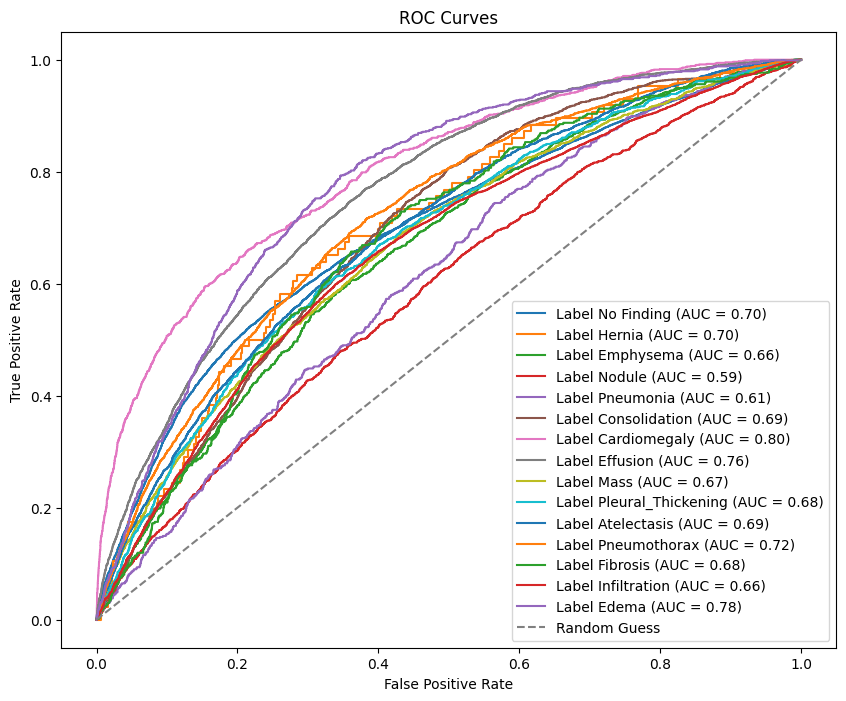

In [69]:
roc_auc(criterion, test_loader, all_preds, all_labels, labels)

In [88]:
def calculate_mse(model, data_loader, device, all_preds, all_labels):
  mse_loss = nn.MSELoss()
  total_loss = 0
  total_losses = torch.zeros(all_preds.size(1), device=device)
  num_samples = 0

  with torch.no_grad():
    # loss for all values
    loss = mse_loss(all_preds, all_labels)
    total_loss += loss.item() * all_preds.size(0)
    # loop for each label
    for i in range(all_preds.size(1)):
      preds = all_preds[:, i]  # Select predictions for a specific label
      labels = all_labels[:, i]  # Select target labels for the same label

      loss = mse_loss(preds, labels)
      total_losses[i] += torch.sum(loss).item()
    num_samples += all_preds.size(0)

  average_loss = total_loss / num_samples
  average_losses = total_losses / num_samples
  return average_loss, average_losses

In [89]:
mse, mse_per_label = calculate_mse(model, test_loader, device, all_preds, all_labels)
print(f"Mean Squared Error (MSE): {mse:.4f}")
for label_index, mse in enumerate(mse_per_label):
    print(f"Mean Squared Error (MSE) for Label {label_index}: {mse:.9f}")

Mean Squared Error (MSE): 0.0730
Mean Squared Error (MSE) for Label 0: 0.000008431
Mean Squared Error (MSE) for Label 1: 0.000000131
Mean Squared Error (MSE) for Label 2: 0.000001599
Mean Squared Error (MSE) for Label 3: 0.000002317
Mean Squared Error (MSE) for Label 4: 0.000000830
Mean Squared Error (MSE) for Label 5: 0.000002503
Mean Squared Error (MSE) for Label 6: 0.000001404
Mean Squared Error (MSE) for Label 7: 0.000005047
Mean Squared Error (MSE) for Label 8: 0.000002440
Mean Squared Error (MSE) for Label 9: 0.000001647
Mean Squared Error (MSE) for Label 10: 0.000004132
Mean Squared Error (MSE) for Label 11: 0.000003614
Mean Squared Error (MSE) for Label 12: 0.000000661
Mean Squared Error (MSE) for Label 13: 0.000006688
Mean Squared Error (MSE) for Label 14: 0.000001326


In [91]:
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(all_labels.cpu().numpy(), all_preds_binary.cpu().numpy())

In [92]:
cm

array([[[13305,  2430],
        [ 5537,  4324]],

       [[25510,     0],
        [   86,     0]],

       [[24503,     0],
        [ 1093,     0]],

       [[23973,     0],
        [ 1623,     0]],

       [[25041,     0],
        [  555,     0]],

       [[23781,     0],
        [ 1815,     0]],

       [[24513,    14],
        [ 1043,    26]],

       [[20782,   156],
        [ 4392,   266]],

       [[23848,     0],
        [ 1748,     0]],

       [[24453,     0],
        [ 1143,     0]],

       [[22317,     0],
        [ 3279,     0]],

       [[22931,     0],
        [ 2665,     0]],

       [[25161,     0],
        [  435,     0]],

       [[19480,     4],
        [ 6111,     1]],

       [[24671,     0],
        [  925,     0]]])

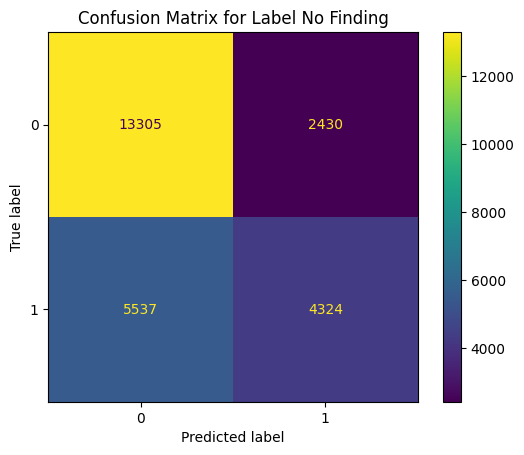

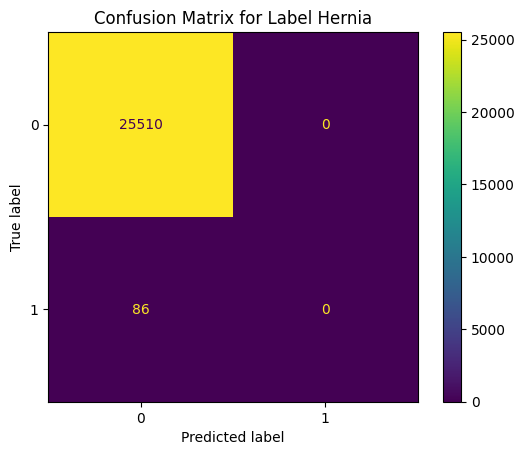

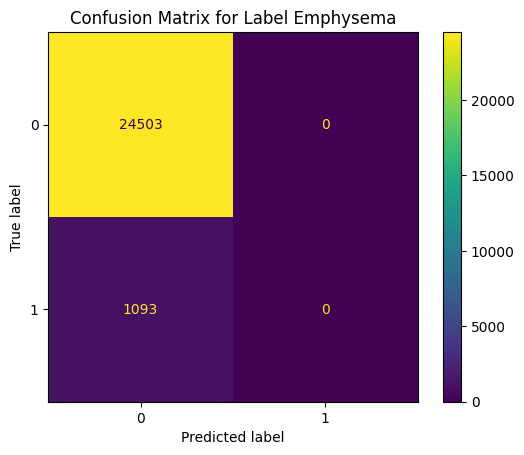

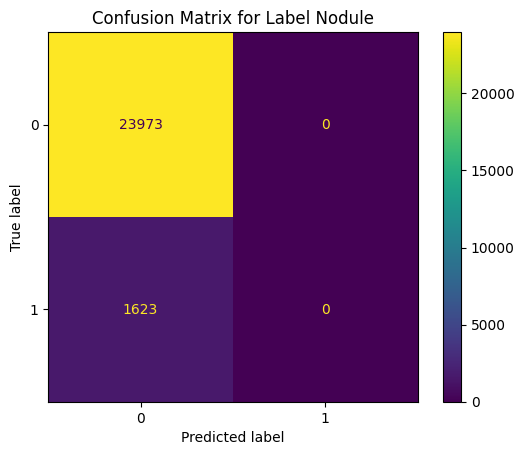

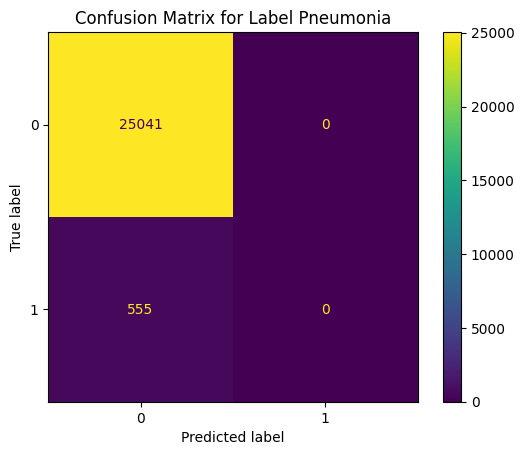

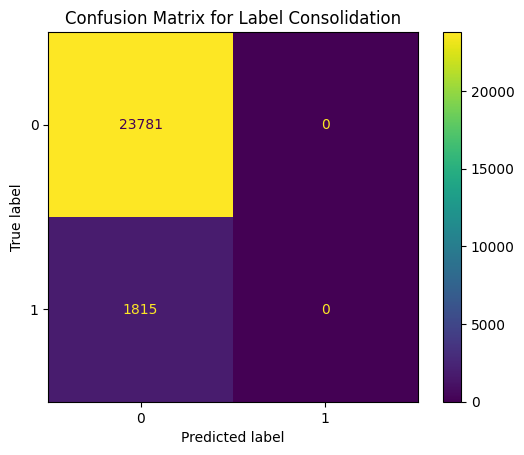

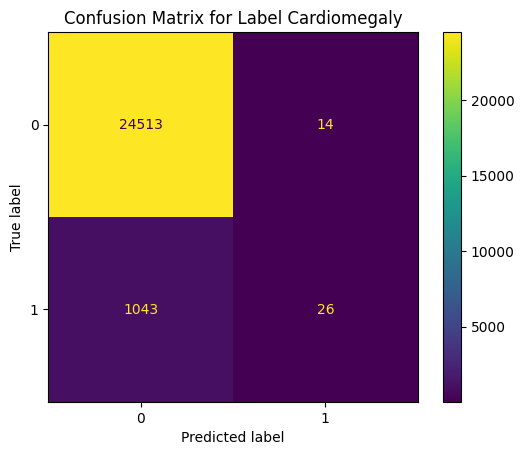

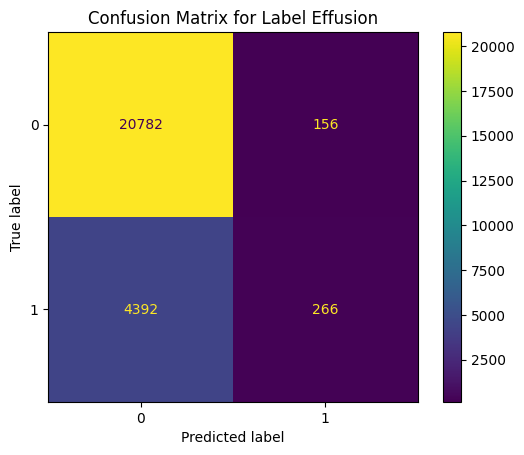

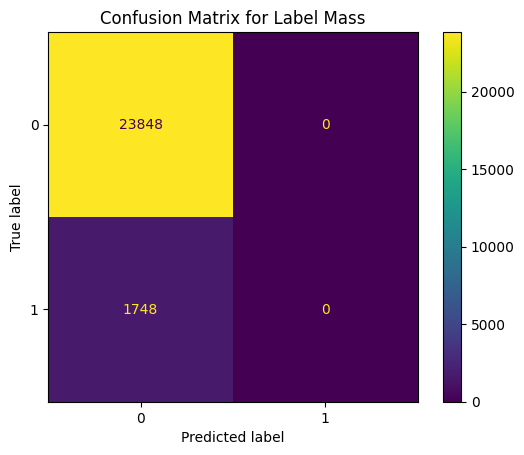

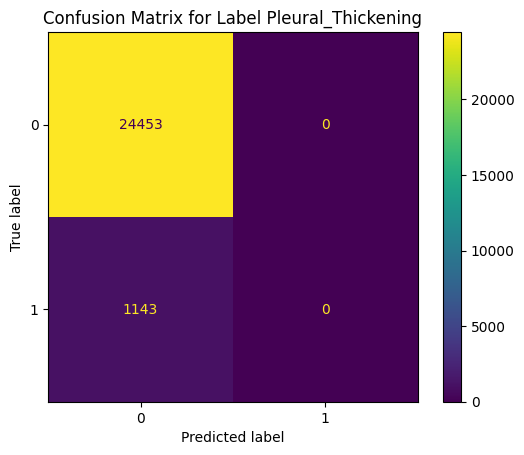

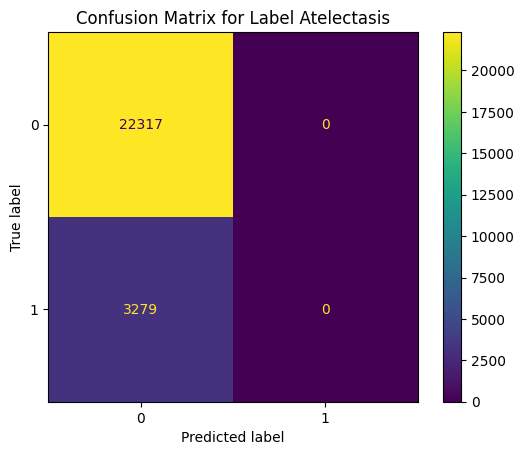

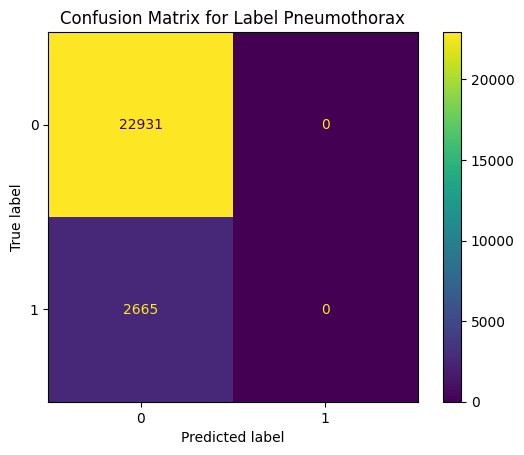

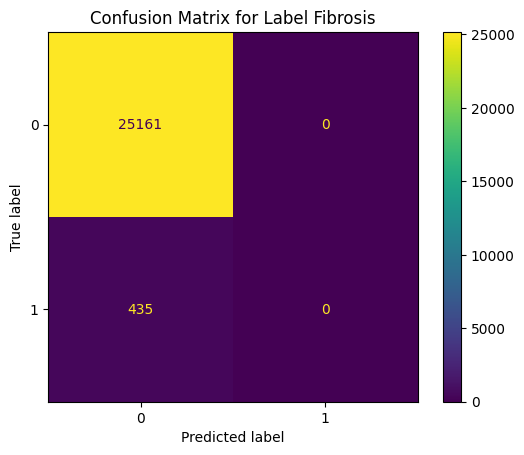

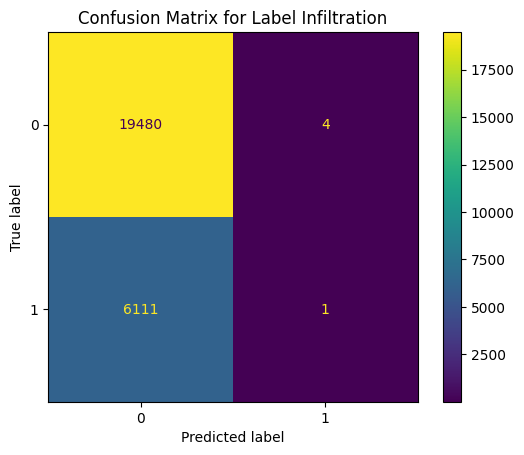

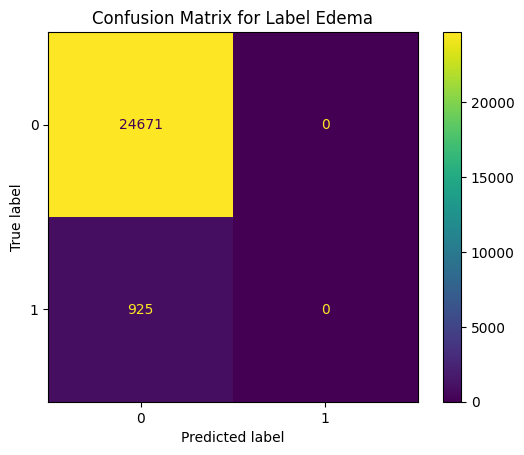

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay

for i in range(cm.shape[0]):
    display = ConfusionMatrixDisplay(confusion_matrix=cm[i])
    fig, ax = plt.subplots()
    display.plot(ax=ax)
    plt.title(f"Confusion Matrix for Label {labels[i]}")
    plt.show()

In [94]:
def calculate_specificity(confusion_matrix):
    true_negatives = confusion_matrix[0, 0]
    false_positives = confusion_matrix[0, 1]
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

In [95]:
def calculate_sensitivity(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_negatives = confusion_matrix[1, 0]
    sensitivity = true_positives / (true_positives + false_negatives)
    return sensitivity

In [96]:
for i in range(len(cm)):
    specificities = calculate_specificity(cm[i])
    sensitivities = calculate_sensitivity(cm[i])
    print(f"Label {labels[i]}: Specificity = {specificities:.4f}, Sensitivity = {sensitivities:.4f}")

Label No Finding: Specificity = 0.8456, Sensitivity = 0.4385
Label Hernia: Specificity = 1.0000, Sensitivity = 0.0000
Label Emphysema: Specificity = 1.0000, Sensitivity = 0.0000
Label Nodule: Specificity = 1.0000, Sensitivity = 0.0000
Label Pneumonia: Specificity = 1.0000, Sensitivity = 0.0000
Label Consolidation: Specificity = 1.0000, Sensitivity = 0.0000
Label Cardiomegaly: Specificity = 0.9994, Sensitivity = 0.0243
Label Effusion: Specificity = 0.9925, Sensitivity = 0.0571
Label Mass: Specificity = 1.0000, Sensitivity = 0.0000
Label Pleural_Thickening: Specificity = 1.0000, Sensitivity = 0.0000
Label Atelectasis: Specificity = 1.0000, Sensitivity = 0.0000
Label Pneumothorax: Specificity = 1.0000, Sensitivity = 0.0000
Label Fibrosis: Specificity = 1.0000, Sensitivity = 0.0000
Label Infiltration: Specificity = 0.9998, Sensitivity = 0.0002
Label Edema: Specificity = 1.0000, Sensitivity = 0.0000


In [97]:
# Function to calculate multi-label accuracy
def accuracy_multi(preds, targs, thresh=0.5):
    preds = (preds.sigmoid() > thresh).float()
    return (preds == targs).float().mean()

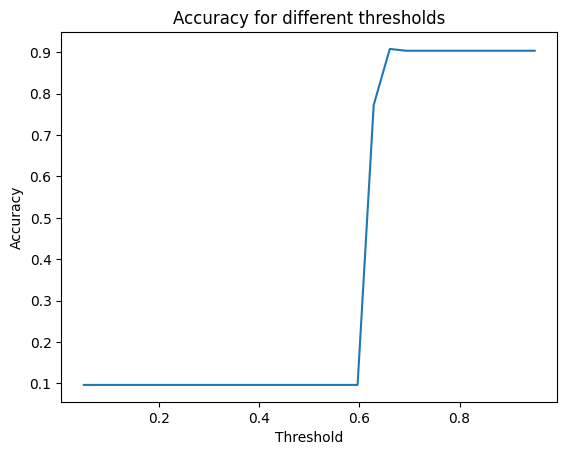

In [98]:
# Calculate accuracies for different thresholds
thresholds = torch.linspace(0.05, 0.95, 29).cpu().numpy()  # Convert to numpy array
accuracies = [accuracy_multi(all_preds_sigmoid, all_labels, thresh=i).cpu().numpy() for i in thresholds]  # Convert to numpy array

# Plot the accuracies
plt.plot(thresholds, accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy for different thresholds")
plt.show()

In [100]:
thresh = 0.65
val_accuracy = accuracy_multi(all_preds_sigmoid, all_labels, thresh).item()
print(f'Epoch 1, Validation Accuracy: {val_accuracy}')

Epoch 1, Validation Accuracy: 0.9066781401634216


In [101]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [102]:
# Concatenate the results
all_preds_np = all_preds_sigmoid.cpu().numpy()
all_labels_np = all_labels.cpu().numpy()

# Calculate and print the F1 score, precision, and recall for each label
num_labels = all_labels_np.shape[1]
for label_index in range(num_labels):
    f1 = f1_score(all_labels_np[:, label_index], all_preds_np[:, label_index] > thresh, zero_division=1)
    precision = precision_score(all_labels_np[:, label_index], all_preds_np[:, label_index] >thresh, zero_division=1)
    recall = recall_score(all_labels_np[:, label_index], all_preds_np[:, label_index] > thresh, zero_division=1)

    print(f'Label {label_index} - F1 score: {f1}, Precision: {precision}, Recall: {recall}')

# Calculate micro and macro averaged F1 score, precision, and recall
micro_f1 = f1_score(all_labels_np, all_preds_np > thresh, average='micro', zero_division=1)
macro_f1 = f1_score(all_labels_np, all_preds_np > thresh, average='macro', zero_division=1)
micro_precision = precision_score(all_labels_np, all_preds_np > thresh, average='micro', zero_division=1)
macro_precision = precision_score(all_labels_np, all_preds_np > thresh, average='macro', zero_division=1)
micro_recall = recall_score(all_labels_np, all_preds_np > thresh, average='micro', zero_division=1)
macro_recall = recall_score(all_labels_np, all_preds_np > thresh, average='macro', zero_division=1)

print(f'Micro-averaged - F1 score: {micro_f1}, Precision: {micro_precision}, Recall: {micro_recall}')
print(f'Macro-averaged - F1 score: {macro_f1}, Precision: {macro_precision}, Recall: {macro_recall}')

Label 0 - F1 score: 0.5204935299428227, Precision: 0.6402132069884513, Recall: 0.43849508163472267
Label 1 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 2 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 3 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 4 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 5 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 6 - F1 score: 0.046889089269612265, Precision: 0.65, Recall: 0.02432179607109448
Label 7 - F1 score: 0.1047244094488189, Precision: 0.6303317535545023, Recall: 0.05710605410047231
Label 8 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 9 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 10 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 11 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 12 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 13 - F1 score: 0.00032695765898316167, Precision: 0.2, Recall: 0.0001636125654450262
Label 14 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Micro-averaged - F1 score: 0.20849891

In [103]:
from sklearn.metrics import hamming_loss, jaccard_score

# Calculate Hamming Loss
hamming_loss_value = hamming_loss(all_labels_np, all_preds_np > thresh)
print(f'Hamming Loss: {hamming_loss_value}')

# Calculate Jaccard Index (Intersection over Union)
jaccard_index = jaccard_score(all_labels_np, all_preds_np > thresh, average='micro')
print(f'Jaccard Index: {jaccard_index}')


Hamming Loss: 0.0913007240714695
Jaccard Index: 0.11638224395654256


In [104]:
# Calculate Exact Match (Accuracy Exact Match)
exact_match = (all_labels_np == (all_preds_np > thresh)).all(axis=1).mean()
print(f'Exact Match (Accuracy Exact Match): {exact_match}')


Exact Match (Accuracy Exact Match): 0.17260509454602282
